## A simple analysis of fNIRs signals with python
The following notebook suggests at a very simple way to process fNIRS signals with the python programming language.
This analysis is missing some key components to improve the SNR of the fNIRS singlas, but is intended as a minimum possible analysis. If possible, try to use the [NICA](https://github.com/praggam/NICA) toolbox. 
Otherwise, you can always use the code in this notebook and complement the analysis. An example of this is adding FIR filters using the scipy `signal` submodule, for DSP. Other option could be adding visualizations or using the peripheric signals form heart and breath.

In [1]:
# !pip install pyxdf  # Install if you havent: uncomment and run cell.
import pyxdf
import numpy as np
import matplotlib.pyplot as plt

The pyxdf library allows loading the `xdf` format in a python object:

In [2]:
# The files contained in the folder `data`, in the same root folder as this notebook.
files = ["data/001.xdf",
         "data/002.xdf",
         "data/003.xdf"]
data, header = pyxdf.load_xdf(files[1])
header

{'info': defaultdict(list, {'version': ['1.0']})}

The object is a list of streams, one for every recorded stream: NIRx, ECG/resp, and paradigm markers. Explore your file to know which stream contain what data.

In [3]:
data[2]

{'info': defaultdict(list,
             {'name': ['PsychopyStream'],
              'type': ['Markers'],
              'channel_count': ['1'],
              'nominal_srate': ['0'],
              'channel_format': ['string'],
              'source_id': ['42'],
              'version': ['1.1000000000000001'],
              'created_at': ['21493.357453000001'],
              'uid': ['e78ba857-820a-4a33-a3b2-78515b6f2585'],
              'session_id': ['default'],
              'hostname': ['DESKTOP-DTOAL1D'],
              'v4address': [None],
              'v4data_port': ['16576'],
              'v4service_port': ['16576'],
              'v6address': [None],
              'v6data_port': ['16576'],
              'v6service_port': ['16576'],
              'desc': [None],
              'stream_id': 2,
              'effective_srate': 0}),
 'footer': {'info': defaultdict(list,
              {'first_timestamp': ['21646.7921071'],
               'last_timestamp': ['22356.7989976'],
            

The markers in this case are contained in the second stream. They can be visualized as vertical lines `vilines` that indicate the onset of each trial. As you can see, the signals do not necessarily have a zero-mean. For this reason, some signals might appear higher in the plot (with a DC offset).

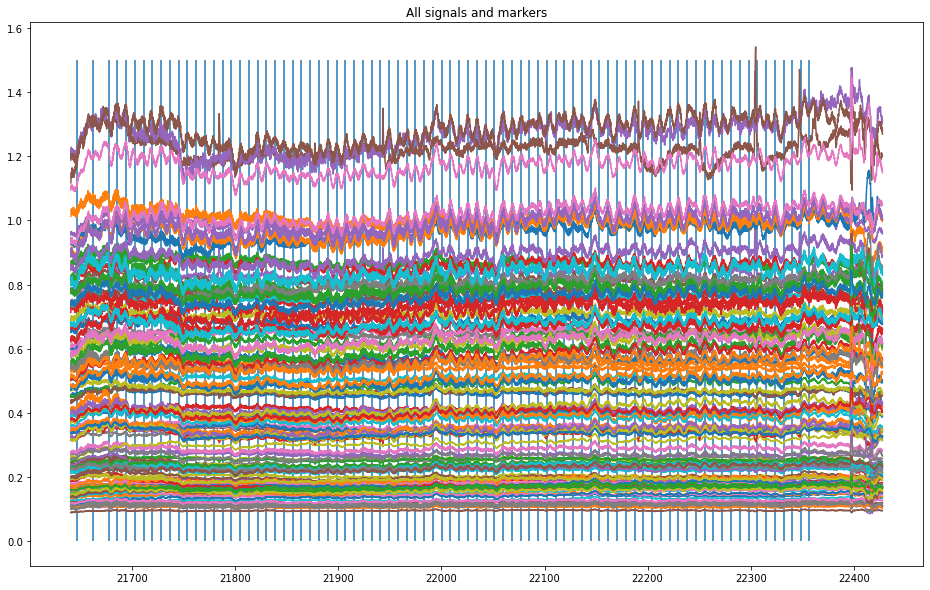

In [4]:
X = data[2]["time_series"]
t = data[2]["time_stamps"]
plt.figure(figsize=(16,10))
plt.title("All signals and markers")
plt.vlines(t, ymax=1.5, ymin=0)
plt.plot(data[1]["time_stamps"], data[1]["time_series"])
plt.show()

## Splitting into individual trials

The extracted signals can be split into individual trials by considering the trigger time. The time indicated by every trigger is used to extract a segment or epoch. The lower bound of the trial is at time $t - L_{b}$ where $t$ is the onset time, and $L_b$ is the baseline time length. The uper bound of the trial is at time $t + L_t + L_p$ Where $t$ is again the onset time, and $L_t$ and $L_p$ are the length of the trial and post-trial time, respectively.

The following example visualizes the first trial with a "R" marker. That is to say the first Right-hand squeeze, including 2 s of baseline, and 2 seconds after the task has stopped.

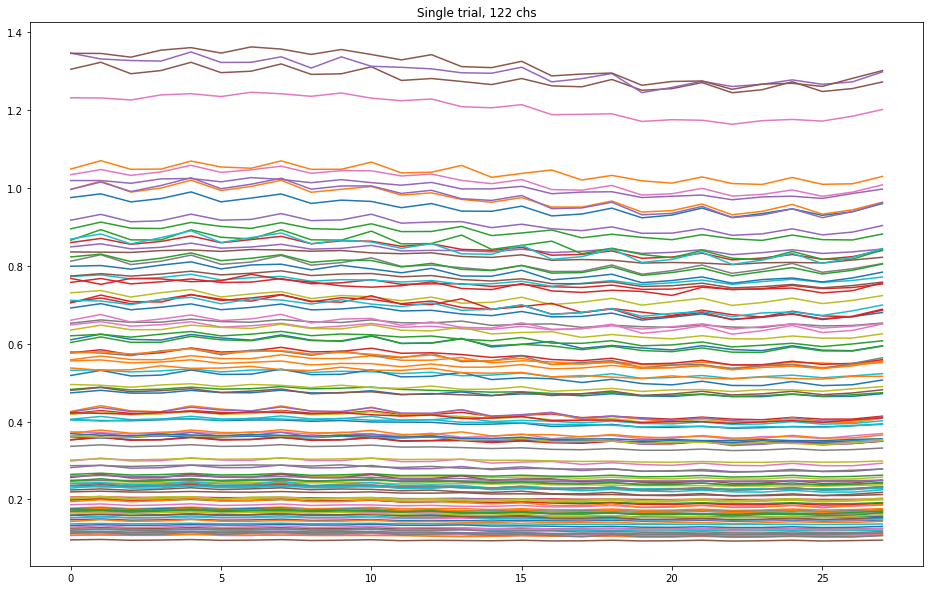

(28, 122)


In [5]:
x = np.array(data[2]["time_series"]).reshape(-1) # Extract the L and R markers
t_r = t[x == np.array(["R"]*len(x))]  # timestamps of Right hand
t_l = t[x == np.array(["L"]*len(x))]  # timestamps of Left hand

# Extracting a single trial
trigger = t_r[1]
baseline = 2.00  # baseline length in ms
task_time = 3.000 # task length in ms
post_task_time = 2.000 # length of time after task to be included
idx = (trigger - baseline <= data[1]["time_stamps"]) & (data[1]["time_stamps"] <= trigger + task_time + post_task_time)
# len(idx) == len(data[1]["time_series"])
trial = data[1]["time_series"][idx]
# print(len(trial))

# Plot a trial
plt.figure(figsize=(16,10))
plt.title("Single trial, 122 chs")
plt.plot(trial)
plt.show()
print(trial.shape)

Once trials are obtained, a simple CAR filtering can be applied to remove the common mean. In the following example, the trials for both classes are stored in the dictionary `class_trials`. You may use this dictionary for your analysis and visualizations.

In [6]:
baseline = 2.0  # baseline length in s
task_time = 3.0 # task length in s
post_task_time = 2.0 # length of time after task to be included
n_sampl = 27  # Number of samples per trial

class_trials = {"Left":[],
                "Right":[]}
for class_label, class_t in zip(class_trials.keys(),[t_r, t_l]):
    trials = np.zeros((27,122,1)) # samples x channels x trials
    for trigger in class_t:
        # Obtaining the indices of the desired timepoints
        idx = (trigger - baseline <= data[1]["time_stamps"]) & (data[1]["time_stamps"] <= trigger + task_time + post_task_time)
        # Setting the trial data inside the time constrain
        trial = data[1]["time_series"][idx]
        # Due to difference in sample frequencies and phases
        # sometimes a trial might have an extra sample point.
        if len(trial) > 27: # Remove extra sample points for dimensionality consistence
            trial = trial[:27]
        trials = np.dstack((trials,trial))
    #     print(trials.shape)
    trials = trials[:,:,1:]  # Remove the first trial in this list, since it's empty.
    
    # Separating oxygenated and de-oxygenated signals
    trials_oxy = trials[:,:61,:]
    trials_dxy = trials[:,61:,:]
    
    # CAR
    avg_oxy = np.mean(trials_oxy, axis=2)
    trials_oxy = trials_oxy - np.expand_dims(avg_oxy, axis=2) # removing the common mean for oxygenated signals
    
    avg_dxy = np.mean(trials_dxy, axis=2)
    trials_dxy = trials_oxy - np.expand_dims(avg_dxy, axis=2) # removing the common mean for de-oxygenated signals
    class_trials[class_label] = np.concatenate((trials_oxy, trials_dxy),axis=1)
    
for v in class_trials:
    print(class_trials[v].shape)

(27, 122, 40)
(27, 122, 40)


## A simple visualization.

The next example shows a simple pre-processing and visualization of the oxygenated and de-oxygenated singals for channels  28, 29, 30, and 31. These channels correspond to the left SMA, corresponding to the controll area for the right hand. For this reason, the class trials for marker "R" are extracted and visualized:

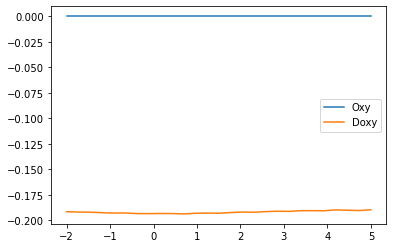

In [7]:
t = np.linspace(-baseline, task_time+post_task_time, num=n_sampl)

# Signal averaging
chs = np.array([28,29,30,31])
avg_oxy_r = class_trials["Right"][:, chs, :].mean(axis=(1,2))
avg_dxy_r = class_trials["Right"][:, chs+61, :].mean(axis=(1,2))

# Viz
plt.plot(t, avg_oxy_r)
plt.plot(t, avg_dxy_r)
plt.legend(["Oxy", "Doxy"])
plt.show()

As mentioned before, these signals have not been filtered, and tend to have a DC offset. This offset can be removed without filtering by use of a baseline average removal:

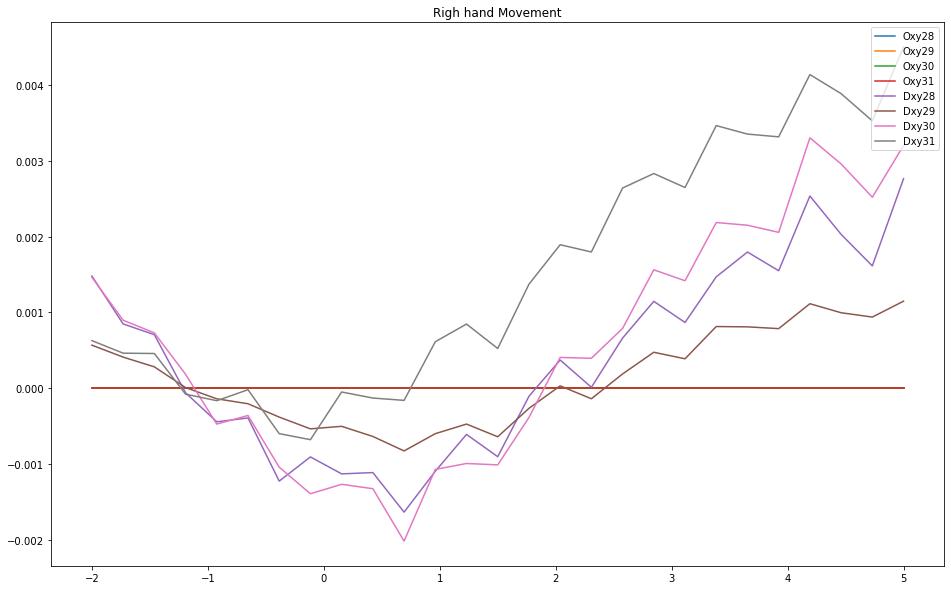

In [8]:
t = np.linspace(-baseline, task_time+post_task_time, num=n_sampl)
chs = np.array([28,29,30,31])

# Class trial extraction
t_oxy_r = class_trials["Right"][:, chs, :]
t_dxy_r = class_trials["Right"][:, chs+61, :]

# Baseline reduction
t_oxy_r = t_oxy_r - np.mean(t_oxy_r[t <= 0], axis=0)
t_dxy_r = t_dxy_r - np.mean(t_dxy_r[t <= 0], axis=0)

# Signal averaging
avg_oxy_r = t_oxy_r.mean(axis=(2))
avg_dxy_r = t_dxy_r.mean(axis=(2))

# Viz
plt.figure(figsize=(16,10))
plt.title("Righ hand Movement")
plt.hlines([0], -2, 5)
plt.plot(t, avg_oxy_r)
plt.plot(t, avg_dxy_r)
plt.legend([f"Oxy{i}" for i in chs] + [f"Dxy{i}" for i in chs], loc="upper right")
plt.show()

The same can be done for the left hand, right SMA channels:

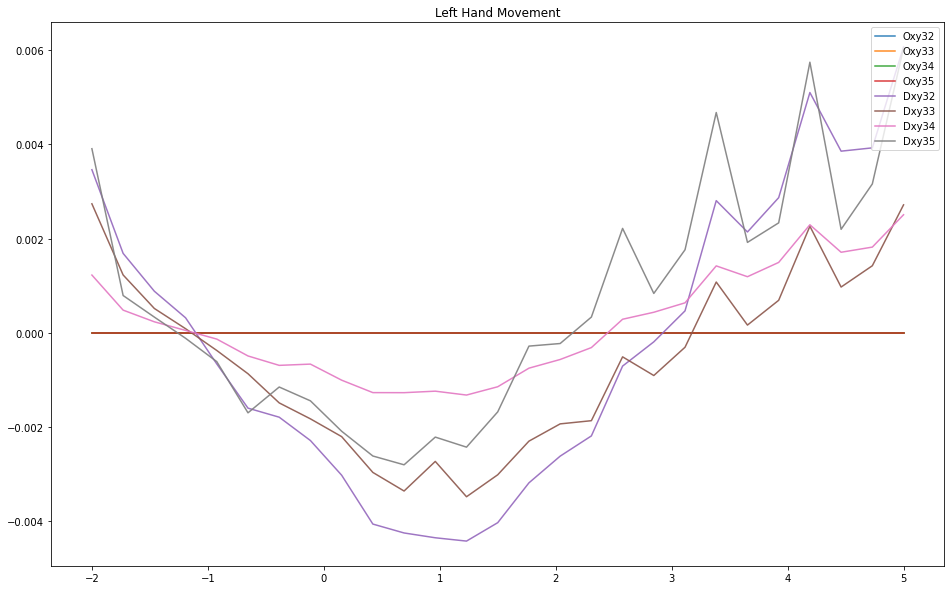

In [9]:
chs = np.array([32,33,34,35])

# Class trial extraction
t_oxy_r = class_trials["Left"][:, chs, :]
t_dxy_r = class_trials["Left"][:, chs+61, :]

# Baseline reduction
t_oxy_r = t_oxy_r - np.mean(t_oxy_r[t <= 0], axis=0)
t_dxy_r = t_dxy_r - np.mean(t_dxy_r[t <= 0], axis=0)

# Signal averaging
avg_oxy_r = t_oxy_r.mean(axis=(2))
avg_dxy_r = t_dxy_r.mean(axis=(2))

# Viz
plt.figure(figsize=(16,10))
plt.title("Left Hand Movement")
plt.hlines([0], -2, 5)
plt.plot(t, avg_oxy_r, alpha=0.9)
plt.plot(t, avg_dxy_r, alpha=0.9)
plt.legend([f"Oxy{i}" for i in chs] + [f"Dxy{i}" for i in chs], loc="upper right")
plt.show()

As you can see the signal processing used in this example is not enough to visualize the expected signal shape, with an initial dxy-Hb dip, a high oxy-Hb consumption during the task, and a refractory period on the oxy-Hb signal. What else could you do to improve the quality of these signals?